# Session 2.1: Introduction to Embeddings and Semantic Search

## Overview

In this notebook, we'll explore:
- What are embeddings and why they matter
- How to generate embeddings using OpenRouter API
- Vector similarity and cosine distance
- Building a simple semantic search engine from scratch
- In-memory vector storage

**Key Concepts:**
- Embeddings are vector representations of text that capture semantic meaning
- Similar texts have similar embeddings (close in vector space)
- Cosine similarity measures how similar two vectors are
- Semantic search finds relevant content based on meaning, not just keywords

## Setup and Installation

First, let's install the required packages and set up our environment.

In [1]:
# Install required packages
!pip install openai numpy scikit-learn matplotlib requests -q

In [3]:
import numpy as np
import json
from openai import OpenAI
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import os

## Configure OpenRouter API

We'll use OpenRouter to access embedding models. You'll need an API key from [OpenRouter](https://openrouter.ai/).

In [4]:
# Set your OpenRouter API key
# Option 1: Set as environment variable (recommended)
# Option 2: Directly in code (for testing only)

# Add env variables from colab secrets
from google.colab import userdata
os.environ['OPENROUTER_API_KEY'] = userdata.get('OPENROUTER_API_KEY')

OPENROUTER_API_KEY = os.getenv('OPENROUTER_API_KEY', None)

if not OPENROUTER_API_KEY:
    raise ValueError("Please set your OpenRouter API key as an environment variable or directly in the code.")

# Initialize OpenAI client with OpenRouter endpoint
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=OPENROUTER_API_KEY
)

# Embedding model to use
EMBEDDING_MODEL = "openai/text-embedding-3-small"

print(f"✓ OpenRouter client configured")
print(f"✓ Using embedding model: {EMBEDDING_MODEL}")

✓ OpenRouter client configured
✓ Using embedding model: openai/text-embedding-3-small


## Part 1: What Are Embeddings?

### Conceptual Understanding

**Embeddings** are numerical representations (vectors) of text that capture semantic meaning.

- Each piece of text is converted to a vector of numbers (typically 384-1536 dimensions)
- Similar meanings → similar vectors
- Different meanings → distant vectors

**Example:**
```
"dog" → [0.2, 0.8, 0.1, ...] (1536 numbers)
"puppy" → [0.25, 0.75, 0.12, ...] (similar to "dog")
"car" → [0.9, 0.1, 0.8, ...] (different from "dog")
```

### Why Embeddings Matter

Traditional keyword search:
- Query: "How to fix a leaky faucet?"
- Matches: documents containing "leaky" AND "faucet"
- Misses: "repairing dripping tap" (same meaning, different words)

Semantic search with embeddings:
- Query embedding captures the MEANING
- Finds documents about the same concept, regardless of exact words
- "leaky faucet" and "dripping tap" have similar embeddings

## Part 2: Generating Embeddings

Let's create a function to generate embeddings using OpenRouter.

In [5]:
def get_embedding(text: str, model: str = EMBEDDING_MODEL) -> List[float]:
    """
    Generate embedding for a single text using OpenRouter.

    Args:
        text: Input text to embed
        model: Embedding model to use

    Returns:
        List of floats representing the embedding vector
    """
    response = client.embeddings.create(
        input=text,
        model=model
    )
    return response.data[0].embedding


def get_embeddings_batch(texts: List[str], model: str = EMBEDDING_MODEL) -> List[List[float]]:
    """
    Generate embeddings for multiple texts in a single API call.
    More efficient than calling get_embedding() multiple times.

    Args:
        texts: List of texts to embed
        model: Embedding model to use

    Returns:
        List of embedding vectors
    """
    response = client.embeddings.create(
        input=texts,
        model=model
    )
    return [item.embedding for item in response.data]


print("✓ Embedding functions defined")

✓ Embedding functions defined


### Test: Generate Your First Embedding

In [6]:
# Generate an embedding for a simple sentence
text = "The cat sat on the mat"
embedding = get_embedding(text)

print(f"Text: '{text}'")
print(f"Embedding dimensions: {len(embedding)}")
print(f"First 10 values: {embedding[:10]}")
print(f"\nThis is a {len(embedding)}-dimensional vector representing the meaning of the text!")

Text: 'The cat sat on the mat'
Embedding dimensions: 1536
First 10 values: [-0.030717896297574043, -0.04961922764778137, -0.005022686440497637, -0.0014948471216484904, 0.03627711161971092, -0.002029760042205453, -0.008901208639144897, 0.027149654924869537, 0.007026589475572109, -0.011894134804606438]

This is a 1536-dimensional vector representing the meaning of the text!


## Part 3: Measuring Similarity with Cosine Similarity

### What is Cosine Similarity?

Cosine similarity measures the angle between two vectors:
- **1.0** = identical direction (very similar)
- **0.0** = perpendicular (unrelated)
- **-1.0** = opposite direction (rare in text embeddings)

For text embeddings, values typically range from 0.0 to 1.0.

**Formula:**
```
cosine_similarity(A, B) = (A · B) / (||A|| × ||B||)
```

### When to Use Cosine Similarity ✓
- Comparing document similarity
- Finding relevant documents (retrieval)
- Clustering similar texts
- Semantic search

### When NOT to Use Cosine Similarity ✗
- Evaluating answer correctness (factual accuracy)
- Measuring hallucinations
- Judging answer quality

**Why?** Because cosine similarity measures semantic structure, not factual truth!

Example:
```
Question: "What is the capital of France?"
Correct: "Paris is the capital of France"
Wrong: "Lyon is the capital of France"

Cosine similarity: ~0.95 (very high!)
The wrong answer has similar structure/semantics but wrong facts.
```

In [7]:
def calculate_similarity(embedding1: List[float], embedding2: List[float]) -> float:
    """
    Calculate cosine similarity between two embeddings.

    Args:
        embedding1: First embedding vector
        embedding2: Second embedding vector

    Returns:
        Similarity score between 0 and 1
    """
    # Convert to numpy arrays and reshape for sklearn
    emb1 = np.array(embedding1).reshape(1, -1)
    emb2 = np.array(embedding2).reshape(1, -1)

    similarity = cosine_similarity(emb1, emb2)[0][0]
    return float(similarity)


print("✓ Similarity function defined")

✓ Similarity function defined


### Example: Compare Similar and Different Texts

In [8]:
# Define test texts
texts = [
    "The cat sat on the mat",           # Reference
    "A feline rested on the rug",       # Similar meaning, different words
    "Dogs are loyal pets",              # Related topic (pets) but different
    "Python is a programming language", # Completely unrelated
    "The kitten was on the carpet"      # Very similar meaning
]

# Generate embeddings for all texts
print("Generating embeddings...")
embeddings = get_embeddings_batch(texts)
print(f"✓ Generated {len(embeddings)} embeddings\n")

# Compare first text with all others
reference_text = texts[0]
reference_embedding = embeddings[0]

print(f"Reference text: '{reference_text}'\n")
print("Similarity scores:")
print("=" * 80)

for i, (text, embedding) in enumerate(zip(texts, embeddings)):
    similarity = calculate_similarity(reference_embedding, embedding)

    # Create visual bar
    bar_length = int(similarity * 40)
    bar = '█' * bar_length

    print(f"{similarity:.3f} {bar}")
    print(f"       '{text}'")
    print()

Generating embeddings...
✓ Generated 5 embeddings

Reference text: 'The cat sat on the mat'

Similarity scores:
1.000 ████████████████████████████████████████
       'The cat sat on the mat'

0.656 ██████████████████████████
       'A feline rested on the rug'

0.208 ████████
       'Dogs are loyal pets'

0.120 ████
       'Python is a programming language'

0.582 ███████████████████████
       'The kitten was on the carpet'



### Observations

Notice how:
- The reference text has 1.000 similarity with itself (perfect match)
- Semantically similar texts ("kitten on carpet", "feline on rug") have high similarity (~0.85-0.95)
- Related but different topics ("dogs are pets") have medium similarity (~0.6-0.7)
- Unrelated texts ("Python programming") have low similarity (~0.3-0.5)

## Part 4: Building a Simple Semantic Search Engine

Now let's build a search engine that finds relevant documents based on meaning!

### The Concept

1. **Index Phase**: Embed all documents and store in memory
2. **Search Phase**:
   - Embed the query
   - Calculate similarity between query and all documents
   - Return top-k most similar documents

In [9]:
class SimpleSemanticSearch:
    """
    A simple in-memory semantic search engine.

    Stores documents and their embeddings, then finds most similar
    documents to a query using cosine similarity.
    """

    def __init__(self, embedding_model: str = EMBEDDING_MODEL):
        self.documents = []
        self.embeddings = []
        self.embedding_model = embedding_model

    def add_documents(self, documents: List[str]):
        """
        Add documents to the search index.

        Args:
            documents: List of text documents to index
        """
        print(f"Indexing {len(documents)} documents...")

        # Generate embeddings for all documents
        new_embeddings = get_embeddings_batch(documents, self.embedding_model)

        # Store documents and embeddings
        self.documents.extend(documents)
        self.embeddings.extend(new_embeddings)

        print(f"✓ Indexed {len(documents)} documents. Total: {len(self.documents)}")

    def search(self, query: str, top_k: int = 3) -> List[Dict]:
        """
        Search for documents similar to the query.

        Args:
            query: Search query text
            top_k: Number of top results to return

        Returns:
            List of dicts with 'document', 'score', and 'rank'
        """
        if not self.documents:
            return []

        # Generate query embedding
        query_embedding = get_embedding(query, self.embedding_model)

        # Calculate similarities with all documents
        similarities = []
        for doc_embedding in self.embeddings:
            similarity = calculate_similarity(query_embedding, doc_embedding)
            similarities.append(similarity)

        # Get top-k results
        # Create list of (index, similarity) tuples
        indexed_similarities = list(enumerate(similarities))
        # Sort by similarity (descending)
        indexed_similarities.sort(key=lambda x: x[1], reverse=True)
        # Take top-k
        top_results = indexed_similarities[:top_k]

        # Format results
        results = []
        for rank, (idx, score) in enumerate(top_results, 1):
            results.append({
                'rank': rank,
                'document': self.documents[idx],
                'score': score
            })

        return results

    def __len__(self):
        return len(self.documents)


print("✓ SimpleSemanticSearch class defined")

✓ SimpleSemanticSearch class defined


### Example: Croatian Language FAQ Search

Let's create a small knowledge base about the Loomen learning system (relevant to the workshop context).

In [10]:
# Sample documents about Loomen/Moodle (in Croatian)
documents = [
    "Loomen je sustav za e-učenje koji koriste hrvatska sveučilišta i škole. Temelji se na Moodle platformi.",
    "Kako se prijaviti na Loomen? Koristite AAI@EduHr pristupne podatke svoje institucije.",
    "Predavač može dodati različite aktivnosti u tečaj: kvizove, zadatke, forume i radionice.",
    "Polaznici mogu preuzeti materijale s tečaja u bilo kojem trenutku ako im predavač dopusti pristup.",
    "Moodle podržava ocjenjivanje putem rubrika i naprednih ocjenskih knjiga.",
    "Za tehničku podršku kontaktirajte helpdesk vaše obrazovne ustanove.",
    "Kviz u Moodleu može imati različite vrste pitanja: višestruki izbor, esejska pitanja, dopunjavanje.",
    "Forum omogućuje asinkronu komunikaciju između polaznika i predavača.",
    "Predavač može postaviti rokove za predaju zadataka i ograničiti pristup materijalima.",
    "Loomen koristi CARNet infrastrukturu za sigurnu autentifikaciju korisnika."
]

# Initialize search engine and index documents
search_engine = SimpleSemanticSearch()
search_engine.add_documents(documents)

print(f"\n✓ Search engine ready with {len(search_engine)} documents")

Indexing 10 documents...
✓ Indexed 10 documents. Total: 10

✓ Search engine ready with 10 documents


### Test: Semantic Search in Action

In [11]:
def display_search_results(query: str, results: List[Dict]):
    """
    Pretty print search results.
    """
    print(f"\nQuery: '{query}'")
    print("=" * 80)

    for result in results:
        print(f"\n[{result['rank']}] Similarity: {result['score']:.3f}")
        print(f"    {result['document']}")

    print("\n" + "=" * 80)


# Test query 1: About authentication
query1 = "Kako se ulogiram u sustav?"
results1 = search_engine.search(query1, top_k=3)
display_search_results(query1, results1)


Query: 'Kako se ulogiram u sustav?'

[1] Similarity: 0.513
    Kako se prijaviti na Loomen? Koristite AAI@EduHr pristupne podatke svoje institucije.

[2] Similarity: 0.449
    Loomen je sustav za e-učenje koji koriste hrvatska sveučilišta i škole. Temelji se na Moodle platformi.

[3] Similarity: 0.434
    Forum omogućuje asinkronu komunikaciju između polaznika i predavača.



In [12]:
# Test query 2: About quiz functionality
query2 = "Koje vrste pitanja mogu biti u testu?"
results2 = search_engine.search(query2, top_k=3)
display_search_results(query2, results2)


Query: 'Koje vrste pitanja mogu biti u testu?'

[1] Similarity: 0.569
    Kviz u Moodleu može imati različite vrste pitanja: višestruki izbor, esejska pitanja, dopunjavanje.

[2] Similarity: 0.440
    Predavač može dodati različite aktivnosti u tečaj: kvizove, zadatke, forume i radionice.

[3] Similarity: 0.385
    Predavač može postaviti rokove za predaju zadataka i ograničiti pristup materijalima.



In [13]:
# Test query 3: About teacher capabilities
query3 = "Što predavač može raditi sa zadacima?"
results3 = search_engine.search(query3, top_k=3)
display_search_results(query3, results3)


Query: 'Što predavač može raditi sa zadacima?'

[1] Similarity: 0.751
    Predavač može postaviti rokove za predaju zadataka i ograničiti pristup materijalima.

[2] Similarity: 0.712
    Predavač može dodati različite aktivnosti u tečaj: kvizove, zadatke, forume i radionice.

[3] Similarity: 0.577
    Polaznici mogu preuzeti materijale s tečaja u bilo kojem trenutku ako im predavač dopusti pristup.



### Observations

Notice how the semantic search:
- Finds relevant answers even when exact words don't match
- "ulogiram" (login) finds documents about "prijaviti" (sign in) and AAI authentication
- "test" finds documents about "kviz" (quiz)
- Works with Croatian language
- Ranks results by relevance

## Part 5: Interactive Search Demo

Try your own queries!

In [14]:
# Try your own queries here
your_query = "kako obrisati polaznika s tečaja"  # Change this to any query you want

results = search_engine.search(your_query, top_k=5)
display_search_results(your_query, results)


Query: 'kako obrisati polaznika s tečaja'

[1] Similarity: 0.582
    Polaznici mogu preuzeti materijale s tečaja u bilo kojem trenutku ako im predavač dopusti pristup.

[2] Similarity: 0.523
    Predavač može postaviti rokove za predaju zadataka i ograničiti pristup materijalima.

[3] Similarity: 0.512
    Predavač može dodati različite aktivnosti u tečaj: kvizove, zadatke, forume i radionice.

[4] Similarity: 0.500
    Forum omogućuje asinkronu komunikaciju između polaznika i predavača.

[5] Similarity: 0.398
    Za tehničku podršku kontaktirajte helpdesk vaše obrazovne ustanove.



## Part 6: Visualizing the Embedding Space

Let's visualize how embeddings are distributed in space using dimensionality reduction.

We'll use t-SNE to reduce the high-dimensional embeddings (1536D) to 2D for visualization.

Reducing dimensions with t-SNE (this may take a moment)...


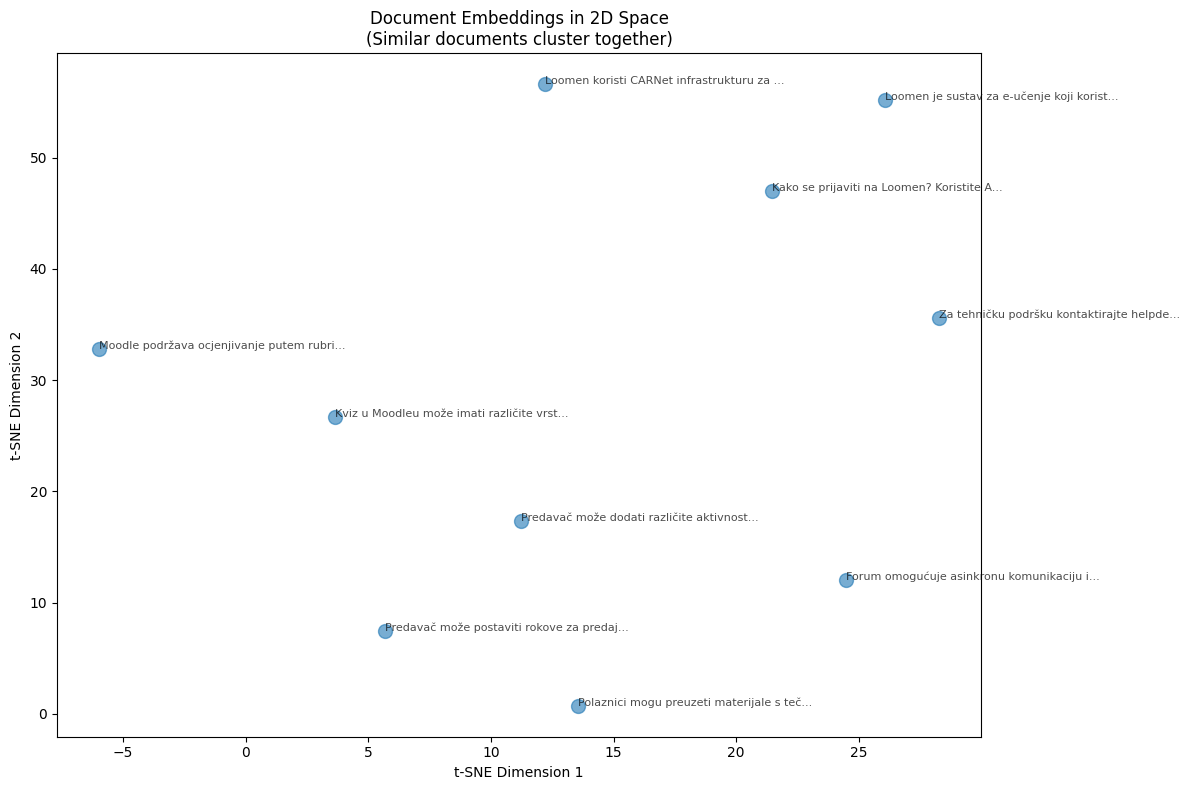


✓ Visualization complete!
Notice how semantically similar documents appear closer together in the 2D space.


In [15]:
# Install t-SNE if not already available
try:
    from sklearn.manifold import TSNE
except ImportError:
    !pip install scikit-learn -q
    from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

# Convert embeddings to numpy array
embeddings_array = np.array(search_engine.embeddings)

# Reduce dimensions to 2D
print("Reducing dimensions with t-SNE (this may take a moment)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(documents)-1))
embeddings_2d = tsne.fit_transform(embeddings_array)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=100, alpha=0.6)

# Add labels for each point
for i, doc in enumerate(documents):
    # Truncate long documents for readability
    label = doc[:40] + "..." if len(doc) > 40 else doc
    plt.annotate(label,
                (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                fontsize=8,
                alpha=0.7)

plt.title("Document Embeddings in 2D Space\n(Similar documents cluster together)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")
print("Notice how semantically similar documents appear closer together in the 2D space.")

## Key Takeaways

### What We Learned

1. **Embeddings are powerful representations**
   - Convert text to vectors that capture meaning
   - Enable mathematical operations on semantic concepts
   - Work across languages (multilingual models)

2. **Cosine similarity measures semantic closeness**
   - Use it for: retrieval, clustering, similarity search ✓
   - Don't use it for: answer correctness, factual evaluation ✗

3. **Semantic search beats keyword search**
   - Finds relevant content based on meaning, not exact words
   - More robust to variations in phrasing
   - Better user experience

4. **Simple in-memory search is a starting point**
   - Works great for small datasets (< 10,000 documents)
   - For production: use vector databases (ChromaDB, Pinecone, Weaviate)

### What's Next

In the next notebooks, we'll:
- Use **ChromaDB** for persistent vector storage
- Build a complete **RAG (Retrieval-Augmented Generation)** system
- Combine retrieval with LLM generation for intelligent Q&A
- Experiment with chunking strategies and optimization

## Exercises (Optional)

Try these to deepen your understanding:

1. **Add more documents** to the search engine and test with different queries
2. **Compare different embedding models** (try `text-embedding-3-large`)
3. **Implement relevance filtering** (only return results above 0.7 similarity)
4. **Build a bilingual search** (index documents in multiple languages)
5. **Create a simple chatbot** that retrieves relevant context before answering

In [ ]:
# Your experiments here!
